# Voice Recognition
Using a triplet loss model, output an encoding that represents signatures of voices. 

## Imports & Setup

In [1]:
from multiprocessing.pool import ThreadPool
import os
import time
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import h5py
from tensorflow.keras.optimizers import (
    Adam
)
from tensorflow.keras.layers import (
    Layer, Input
)
from paiutils.neural_network import Trainer, Predictor
from paiutils import audio
from paiutils.analytics import Analyzer
from paiutils.util_funcs import load_directory_database, save_directory_database
pyaudio = audio.pyaudio

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


C:\Users\Travis\Anaconda3\envs\AIGPU\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.6.0-dev20210413). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Create Data

Load table

In [20]:
sample_rate = 16000
metadata = pd.read_csv('D:\\cv_data\\data.tsv', delimiter='\t')
metadata['path'] = metadata['path'].str.split('.').str[0]
metadata['path'] += '.wav'

Shrink data

In [ ]:
counts = metadata.groupby('sentence')['path'].count()
metadata2 = metadata[metadata['sentence'].isin(counts[10 <= counts].index)]
counts = metadata2.groupby('client_id')['path'].count()
metadata2 = metadata2[metadata2['client_id'].isin(counts[10 <= counts].index)]
metadata2['accent'].value_counts()

In [ ]:
metadata2 = metadata[metadata['sentence'].str.len() > 10]
metadata2 = metadata2[metadata2['down_votes'] == 0]
#metadata2 = metadata2[metadata2['accent'].isin(['us'])]
counts = metadata2.groupby('sentence')['path'].count()
metadata2 = metadata2[metadata2['sentence'].isin(counts[10 <= counts].index)]
counts = metadata2.groupby('client_id')['path'].count()
metadata2 = metadata2[metadata2['client_id'].isin(counts[10 <= counts].index)]
metadata2 = metadata2.groupby('client_id').sample(10)
len(metadata2), len(metadata2['client_id'].unique())
print(len(metadata2)/len(metadata), len(metadata2), len(metadata2['client_id'].unique()), metadata2.groupby('client_id')['path'].count().mean())

In [ ]:
metadata = metadata2
del metadata2
labels = metadata['client_id'].unique()
metadata['client_nid'] = metadata['client_id'].replace(labels, np.arange(len(labels)))
metadata.to_csv('D:\\cv_mutated\\metadata.tsv', sep='\t')
del metadata['Unnamed: 0']
vali_ids = pd.Series(metadata['client_id'].unique()).sample(100)
vali_ids = metadata['client_id'].isin(vali_ids)
train_ids = pd.Series(metadata.loc[~vali_ids, 'client_id'].unique())
train_ids = metadata['client_id'].isin(train_ids)
train_metadata = metadata[train_ids]
vali_metadata = metadata[vali_ids]
train_metadata.to_csv('D:\\cv_mutated\\train_metadata.tsv', sep='\t')
vali_metadata.to_csv('D:\\cv_mutated\\vali_metadata.tsv', sep='\t')

Save data

In [4]:
num_mutations = 4
length = 3

backgrounds = []
for file in os.listdir('D:\\cv_mutated\\background'):
    x, sr, at = audio.load(f'D:\\cv_mutated\\background\\{file}', rate=sample_rate)
    backgrounds += np.array_split(x, np.arange(0, len(x), sample_rate * length)[1:])[:-1]
for path in train_metadata['path'].sample(5000):
    x, sr, at = audio.load(f'D:\\cv_data\\{path}', rate=sample_rate)
    x = np.roll(x, int(len(x) * np.random.random()))
    x = audio.set_duration(x, sample_rate, length)
    backgrounds.append(x)
backgrounds = np.array(backgrounds, dtype=np.float32)

In [26]:
num_mutations = 4
length = 3

lens = []
xs = np.empty((10 * (num_mutations + 1), sample_rate * length), dtype=np.float32)
for group_id, data in metadata[['client_id', 'path']].groupby('client_id'):
    paths = data['path']
    ndx = 0
    for path in paths.values:
        x, sr, at = audio.load(f'D:\\cv_data\\{path}')
        x = audio.vad_trim_all(x, sr, .03, 1)
        lens.append(audio.calc_duration(x, sample_rate))
        xs[ndx] = audio.set_duration(x, sample_rate, length)
        ndx += 1
        for _ in range(num_mutations):
            m = np.random.random()
            #print(m)
            y = np.roll(x, int(len(x) * m))
            y = audio.set_duration(y, sample_rate, length)
            #y = x.copy()
            m = np.random.uniform(.5, 1.5)
            if m > 1:
                m = 1 / (2 - m)
            #print(m)
            y = audio.adjust_volume(y, m)
            m = np.maximum(np.random.uniform(-.2, .2), 0)
            #print(m)
            ym = y[y > 0].mean()
            y += np.random.uniform(low=-ym, high=ym, size=len(y)) * m
            if np.random.random() > .5:
                #m = np.random.uniform(.05, .2)
                m = .2
                m1 = np.random.randint(len(backgrounds))
                #print(m, m1)
                y += audio.set_power(backgrounds[m1], audio.calc_rms(y) * m)
            y = np.clip(y, -1, 1)
            m = np.random.uniform(.97, 1.03)
            if m > 1:
                m = 1 / (2 - m)
            #print(m)
            y = audio.adjust_speed(y, sample_rate, m)
            y = audio.set_duration(y, sample_rate, length)
            #audio.play(backgrounds[m1], sample_rate)
            #audio.play(y, sample_rate)
            xs[ndx] = y
            ndx += 1
    with h5py.File(f'D:\\cv_mutated\\{group_id}.h5', 'w') as file:
        file.create_dataset('data', data=xs)
np.array(lens).mean()

2.88764335231493

## Load Data

Load metadata and split into train and validation

In [3]:
sample_rate = 16000
length = 3
class_size = (4 + 1) * 10
metadata = pd.read_csv('D:\\cv_mutated\\metadata.tsv', delimiter='\t')
del metadata['Unnamed: 0']
train_metadata = pd.read_csv('D:\\cv_mutated\\train_metadata.tsv', sep='\t')
train_metadata_sample = train_metadata[train_metadata['client_id'].isin(pd.Series(train_metadata['client_id'].unique()).sample(200))]
vali_metadata = pd.read_csv('D:\\cv_mutated\\vali_metadata.tsv', sep='\t')

Set nids for metadata

In [4]:
train_labels = train_metadata['client_id'].unique()
train_metadata['client_nid'] = train_metadata['client_id'].replace(train_labels, np.arange(len(train_labels)))

In [5]:
train_labels_sample = train_metadata_sample['client_id'].unique()
train_metadata_sample['client_nid'] = train_metadata_sample['client_id'].replace(train_labels_sample, np.arange(len(train_labels_sample)))

<ipython-input-5-dad806ee35c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_metadata_sample['client_nid'] = train_metadata_sample['client_id'].replace(train_labels_sample, np.arange(len(train_labels_sample)))


In [6]:
vali_labels = vali_metadata['client_id'].unique()
vali_metadata['client_nid'] = vali_metadata['client_id'].replace(vali_labels, np.arange(len(vali_labels)))

Load data

In [7]:
#train_anchors = np.empty((len(train_metadata['client_id'].unique()), class_size, sample_rate * length), dtype=np.float32)
#for group_id, data in train_metadata[['client_id', 'client_nid', 'path']].groupby('client_id'):
#    with h5py.File(f'D:\\cv_mutated\\{group_id}.h5', 'r') as hf:
#        train_anchors[int(data['client_nid'].values[0])] = hf['data'][:]

In [8]:
train_anchors_sample = np.empty((len(train_metadata_sample['client_id'].unique()), class_size, sample_rate * length), dtype=np.float32)
for group_id, data in train_metadata_sample[['client_id', 'client_nid', 'path']].groupby('client_id'):
    with h5py.File(f'D:\\cv_mutated\\{group_id}.h5', 'r') as hf:
        train_anchors_sample[int(data['client_nid'].values[0])] = hf['data'][:]

In [9]:
vali_anchors = np.empty((len(vali_metadata['client_id'].unique()), class_size, sample_rate * length), dtype=np.float32)
for group_id, data in vali_metadata[['client_id', 'client_nid', 'path']].groupby('client_id'):
    with h5py.File(f'D:\\cv_mutated\\{group_id}.h5', 'r') as hf:
        vali_anchors[int(data['client_nid'].values[0])] = hf['data'][:]

In [10]:
#train_anchors.nbytes / 1000000000, 
train_anchors_sample.nbytes / 1000000000, vali_anchors.nbytes / 1000000000

(1.92, 0.96)

In [11]:
#num_mutations = 1
#train_mutated_anchors = np.empty(
#    (len(train_metadata['client_id'].unique()), train_anchors.shape[1] * num_mutations, sample_rate * length), dtype=np.float32
#)
#for cid in range(train_anchors.shape[0]):
#    count = 0
#    for ndx in range(train_anchors.shape[1]):
#        x = train_anchors[cid, ndx]
#        for _ in range(num_mutations):
#            m = np.random.random()
#            #print(m)
#            y = np.roll(x, int(len(x) * m))
#            #y = x.copy()
#            m = np.random.uniform(.5, 1.5)
#            if m > 1:
#                m = 1 / (2 - m)
#            #print(m)
#            y = audio.adjust_volume(y, m)
#            m = np.maximum(np.random.uniform(-.2, .2), 0)
#            #print(m)
#            ym = y[y > 0].mean()
#            y += np.random.uniform(low=-ym, high=ym, size=len(y)) * m
#            y = np.clip(-1, 1, y)
#            m = np.random.uniform(.97, 1.03)
#            if m > 1:
#                m = 1 / (2 - m)
#            #print(m)
#            y = audio.adjust_speed(y, sample_rate, m)
#            y = audio.set_duration(y, sample_rate, length)
#            #audio.play(x, sample_rate)
#            #audio.play(y, sample_rate)
#            train_mutated_anchors[cid, count] = y
#            count += 1
#train_anchors = np.hstack([train_anchors, train_mutated_anchors])
#train_anchors = np.expand_dims(train_anchors, axis=-1)

In [12]:
train_anchors_sample = np.expand_dims(train_anchors_sample, axis=-1)

In [13]:
vali_anchors = np.expand_dims(vali_anchors, axis=-1)

## Model

In [22]:
x0 = keras.layers.Input(shape=train_anchors_sample.shape[2:])
x = keras.layers.Conv1D(32, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x0)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(32, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(32, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(32, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(64, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(64, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(64, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(64, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(128, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(128, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(128, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Conv1D(128, 3, 2, activation='swish', kernel_initializer='he_normal', padding='same')(x)
x = keras.layers.Dropout(0.1)(x)
#x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Flatten()(x)
dense_layer = keras.layers.Dense(128, activation=None, kernel_initializer='he_normal')(x)
norm_layer = keras.layers.Lambda(lambda  x: tf.math.l2_normalize(x, axis=1))(dense_layer)
model = keras.Model(inputs=x0, outputs=norm_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48000, 1)]        0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 24000, 32)         128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 24000, 32)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 12000, 32)         3104      
_________________________________________________________________
dropout_13 (Dropout)         (None, 12000, 32)         0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 6000, 32)          3104      
_________________________________________________________________
dropout_14 (Dropout)         (None, 6000, 32)          0   

### Train

In [23]:
def triplet_generator_load(metadata, batch_size, reload, sample_size, class_size, threads=4):
    while True:
        ids = pd.Series(metadata['client_id'].unique()).sample(sample_size)
        metadata_sample = metadata[metadata['client_id'].isin(ids)]
        anchors = np.empty((sample_size, class_size, sample_rate * length), dtype=np.float32)
        #for group_id, data in metadata_sample[['client_id', 'client_nid', 'path']].groupby('client_id'):
        #    with h5py.File(f'D:\\cv_mutated\\{group_id}.h5', 'r') as hf:
        #        anchors[int(data['client_nid'].values[0])] = hf['data'][:]
                
        def load(x):
            nonlocal anchors
            ndx, (group_id, data) = x
            with h5py.File(f'D:\\cv_mutated\\{group_id}.h5', 'r') as hf:
                anchors[ndx] = hf['data'][:]  
               
        #s = time.time()
        with ThreadPool(threads) as p:
            p.map(load, zip(np.arange(sample_size), metadata_sample[['client_id', 'path']].groupby('client_id')))
        #print(time.time()-s)
        
        anchors = np.expand_dims(anchors, axis=-1)
                
        for _ in range(reload):
            a_ndxs = np.random.choice(np.arange(len(anchors)), size=batch_size)
            a_ndxs2 = np.random.choice(np.arange(len(anchors[0])), size=batch_size)
            p_ndxs = np.random.choice(np.arange(len(anchors[0])), size=batch_size)
            n_ndxs = np.random.choice(np.arange(len(anchors) - 1), size=batch_size)
            n_ndxs[n_ndxs >= a_ndxs] += 1
            n_ndxs2 = np.random.choice(np.arange(len(anchors[0])), size=batch_size)
            nn_ndxs = np.random.choice(np.arange(len(anchors[0])), size=batch_size)

            a_batch = anchors[a_ndxs, a_ndxs2]
            p_batch = anchors[a_ndxs, p_ndxs]
            n_batch = anchors[n_ndxs, n_ndxs2]
            nn_batch = anchors[n_ndxs, nn_ndxs]

            ndxs = np.hstack([a_ndxs, a_ndxs, n_ndxs, n_ndxs])
            batch = np.vstack([a_batch, p_batch, n_batch, nn_batch])
            yield batch, ndxs

In [24]:
def triplet_generator(anchors, batch_size):
    while True:
        a_ndxs = np.random.choice(np.arange(len(anchors)), size=batch_size)
        a_ndxs2 = np.random.choice(np.arange(len(anchors[0])), size=batch_size)
        p_ndxs = np.random.choice(np.arange(len(anchors[0])), size=batch_size)
        n_ndxs = np.random.choice(np.arange(len(anchors) - 1), size=batch_size)
        n_ndxs[n_ndxs >= a_ndxs] += 1
        n_ndxs2 = np.random.choice(np.arange(len(anchors[0])), size=batch_size)
        nn_ndxs = np.random.choice(np.arange(len(anchors[0])), size=batch_size)

        a_batch = anchors[a_ndxs, a_ndxs2]
        p_batch = anchors[a_ndxs, p_ndxs]
        n_batch = anchors[n_ndxs, n_ndxs2]
        nn_batch = anchors[n_ndxs, nn_ndxs]
        
        ndxs = np.hstack([a_ndxs, a_ndxs, n_ndxs, n_ndxs])
        batch = np.vstack([a_batch, p_batch, n_batch, nn_batch])
        yield batch, ndxs

In [25]:
def paccuracy(y_true, y_pred):
    batch_size = len(y_true) // 4
    anchors = y_pred[:batch_size, :]
    postives = y_pred[batch_size:batch_size * 2, :]
    negatives = y_pred[batch_size * 2: batch_size * 3]
    nnegatives = y_pred[batch_size * 3:]
    
    a = tf.norm(postives - anchors, axis=-1)
    a = tf.reduce_sum(tf.cast(a < 1.0, tf.int32), axis=-1)
    
    b = tf.norm(negatives - nnegatives, axis=-1)
    b = tf.reduce_sum(tf.cast(b < 1.0, tf.int32), axis=-1)
    
    return (a + b) / (batch_size * 2)

def naccuracy(y_true, y_pred):
    batch_size = len(y_true) // 4
    anchors = y_pred[:batch_size, :]
    postives = y_pred[batch_size:batch_size * 2, :]
    negatives = y_pred[batch_size * 2: batch_size * 3]
    nnegatives = y_pred[batch_size * 3:]
    
    a = tf.norm(negatives - anchors, axis=-1)
    a = tf.reduce_sum(tf.cast(a > 1.0, tf.int32), axis=-1)
    
    b = tf.norm(postives - negatives, axis=-1)
    b = tf.reduce_sum(tf.cast(b > 1.0, tf.int32), axis=-1)

    c = tf.norm(nnegatives - anchors, axis=-1)
    c = tf.reduce_sum(tf.cast(c > 1.0, tf.int32), axis=-1)
    
    d = tf.norm(postives - nnegatives, axis=-1)
    d = tf.reduce_sum(tf.cast(d > 1.0, tf.int32), axis=-1)
    
    return (a + b + c + d) / (batch_size * 4)

In [20]:
batch_size = 32
steps = int(len(train_metadata['client_id'].unique()) * class_size / batch_size) // 4
vali_steps = int(len(vali_anchors) * len(vali_anchors[0]) / batch_size) // 4
trainer = Trainer(model, {'train': triplet_generator_load(train_metadata, batch_size, steps // 4, 2000, class_size, threads=10),
                          'validation': triplet_generator(vali_anchors, batch_size)})
trainer.model.compile(optimizer=Adam(.001),
                      loss=tfa.losses.TripletSemiHardLoss(1.0), metrics=[paccuracy, naccuracy])
trainer.load('20210826_221821_513997')
#for ndx, layer in enumerate(trainer.model.layers[:-2]):
#    model.layers[ndx].set_weights(layer.get_weights())
#trainer.model = model

In [ ]:
callbacks = [keras.callbacks.TensorBoard(log_dir='logs/training/' + time.strftime(r'%Y%m%d_%H%M%S'), histogram_freq=1)]
for _ in range(4):
    trainer.train(epochs=10, steps_per_epoch=steps, validation_steps=vali_steps, callbacks=callbacks)
    path = trainer.save('')

## Test

In [20]:
#path = '20210818_093422_095947'
predictor = Predictor(path)

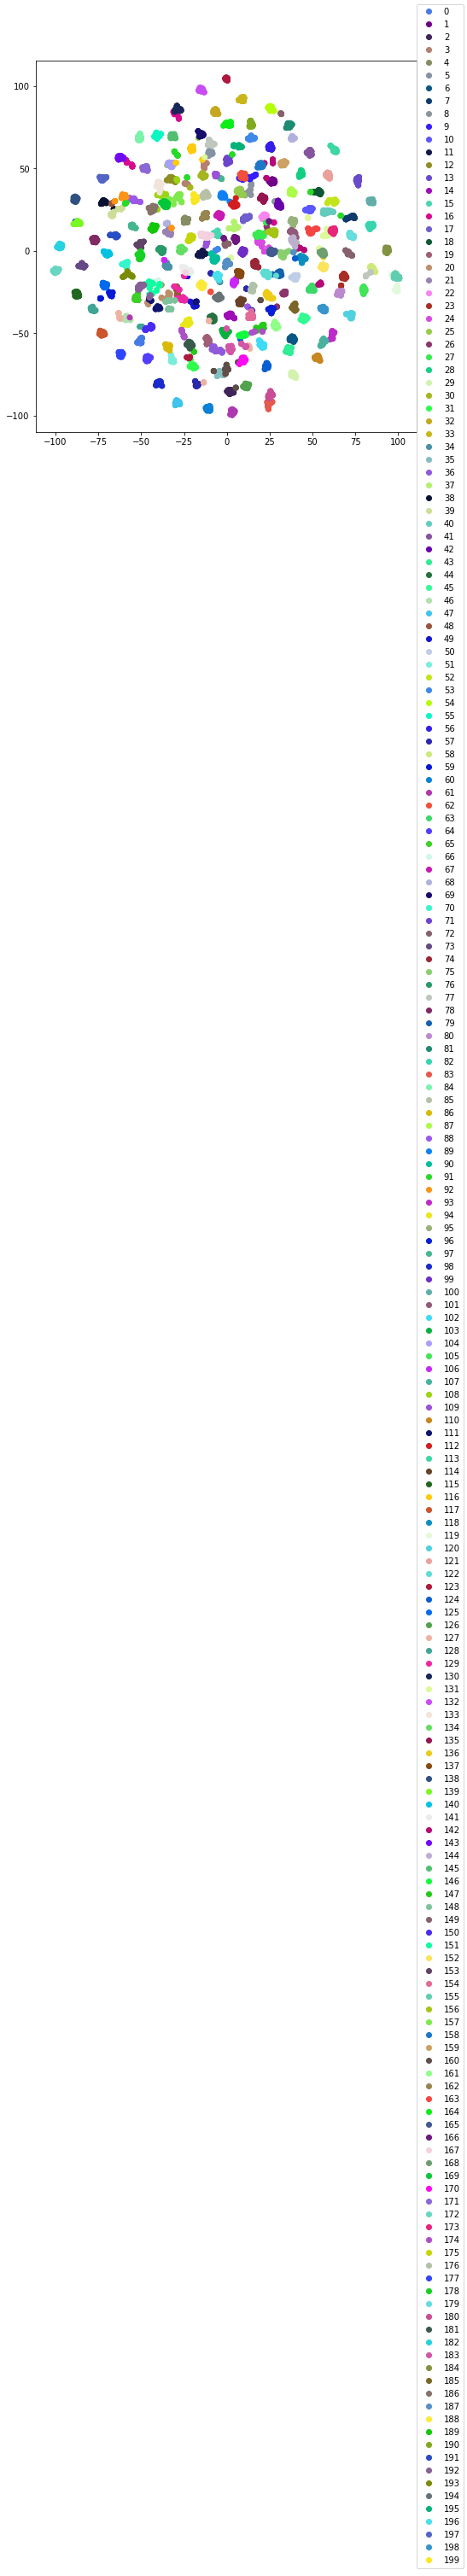

array([[-49.60707 , -53.0455  ],
       [-49.502224, -52.870552],
       [-49.5573  , -53.00346 ],
       ...,
       [-19.264862,  34.275715],
       [-19.321585,  34.240116],
       [-19.261122,  34.293102]], dtype=float32)

In [21]:
xs = []
ys = []
labels = []
count = 0
for ndx, anchor_class in enumerate(train_anchors_sample):
    for anchor in anchor_class:
        xs.append(predictor.predict(anchor))
        ys.append(count)
    count += 1
    labels.append(ndx)
analyzer = Analyzer(xs, ys, labels)
analyzer.plot(analyzer.tsne(2, n_jobs=-1))

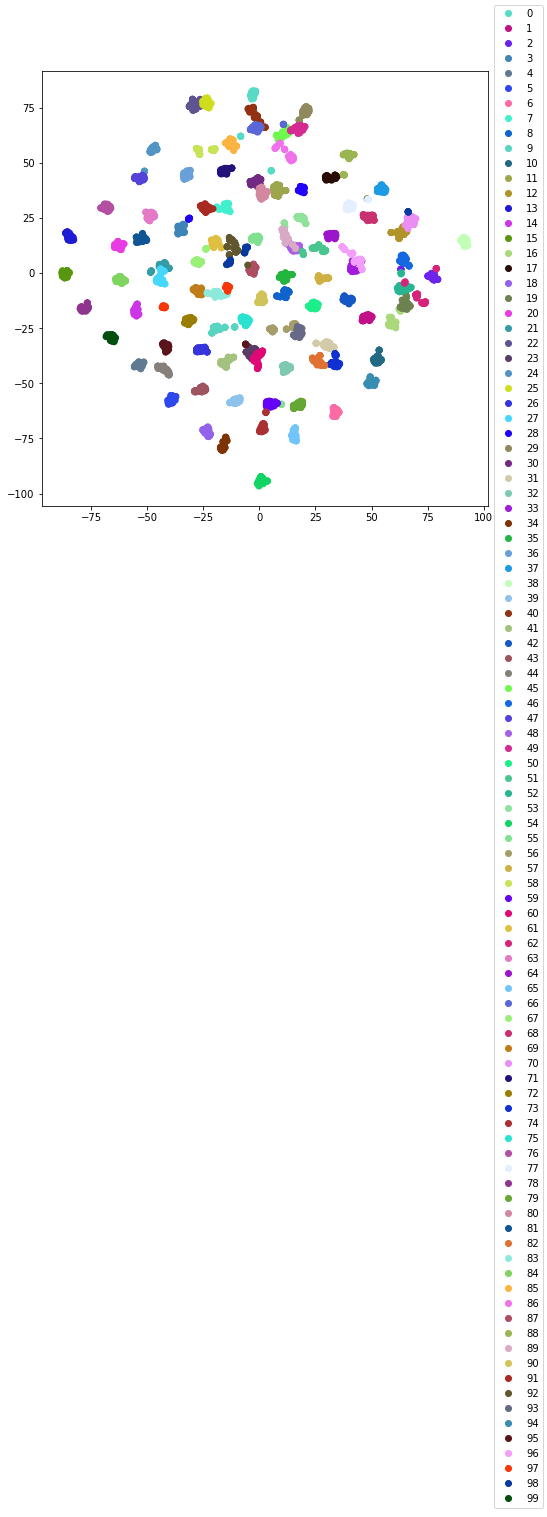

array([[  5.2684326,  46.42925  ],
       [  5.2922096,  46.462654 ],
       [  5.283949 ,  46.474827 ],
       ...,
       [-66.50007  , -30.506847 ],
       [-65.92762  , -30.58851  ],
       [-66.287926 , -30.170116 ]], dtype=float32)

In [22]:
xs = []
ys = []
labels = []
count = 0
for ndx, anchor_class in enumerate(vali_anchors):
    for anchor in anchor_class:
        xs.append(predictor.predict(anchor))
        ys.append(count)
    count += 1
    labels.append(ndx)
analyzer = Analyzer(xs, ys, labels)
analyzer.plot(analyzer.tsne(2, n_jobs=-1))

## Live Test

In [ ]:
path = '20210822_164154_339789'
predictor = Predictor(path)

In [23]:
def live_recognition(predictor, length, rate):
    p = pyaudio.PyAudio()
    patype = pyaudio.paInt16
    stream = p.open(format=patype,
                    channels=1,
                    rate=rate,
                    input=True,
                    frames_per_buffer=4096)
    unique_recordings = []
    frames = []
    while True:
        frames = np.append(frames, np.frombuffer(stream.read(4096), dtype='int16') / np.iinfo('int16').max)
        if len(frames) > rate * length:
            x = frames[-rate * length:]
            x = audio.vad_trim_all(x, rate, .03, 1)
            x = audio.set_duration(x, rate, 3)
            x = predictor.predict(x)
            unique_recordings.append(x)
            print(np.linalg.norm(np.array(unique_recordings) - x, axis=-1))
            frames = []
    stream.stop_stream()
    stream.close()
    p.terminate()

In [26]:
live_recognition(predictor, 3, sample_rate)

[0.]
[0.46001098 0.        ]
[0.49358913 0.15051425 0.        ]
[0.35434815 0.31565544 0.29769465 0.        ]
[0.4441066  0.32454348 0.26615208 0.19364466 0.        ]
[0.34796715 0.32085994 0.3084646  0.32496008 0.34450632 0.        ]
[0.5740194  0.24368705 0.18782891 0.36287615 0.36800855 0.3823555
 0.        ]
[0.51058966 0.4023035  0.3723231  0.33186212 0.35891974 0.44678074
 0.45377767 0.        ]
[0.5612857  0.5846335  0.5305764  0.3483102  0.40753475 0.50023067
 0.50471497 0.520934   0.        ]
[0.5230408  0.32359192 0.29633477 0.2512794  0.31511307 0.38014895
 0.2607466  0.38222155 0.3326557  0.        ]
[0.6319528  0.43724793 0.40968883 0.4006733  0.47201666 0.50369716
 0.31800827 0.4996391  0.39824426 0.22297862 0.        ]
[0.80509543 1.1087089  1.101624   0.9173289  0.9428309  0.96496624
 1.1728714  0.9432665  0.9319492  1.0831045  1.169614   0.        ]
[0.5882341  0.78159636 0.7714894  0.5351351  0.5978455  0.685711
 0.82969874 0.5743352  0.52196443 0.66753584 0.77633935 

KeyboardInterrupt: 

In [ ]:
voices = []
while True:
    input('enter to record')
    x, sr, a = audio.record(3, sample_rate)
    #audio.plot(x)
    x = audio.vad_trim_all(x, sample_rate, .03, 1)
    x = audio.set_duration(x, sample_rate, 2)
    #audio.plot(x)
    #audio.play(x, sr)
    x = predictor.predict(x)
    distances = []
    for voice in voices:
        distances.append((np.linalg.norm(voice - x)))
    print(distances)
    voices.append(x)